In [8]:
import cv2
import numpy as np
from ultralytics import YOLO
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
model = YOLO("best.pt")

In [22]:
# Load both videos
broadcast_video = cv2.VideoCapture(r"C:\Users\Rex\ML Projects\Projects\pytorch project\broadcast.mp4")
tactician_video = cv2.VideoCapture(r"C:\Users\Rex\ML Projects\Projects\pytorch project\tacticam.mp4")

In [38]:
import os
import cv2

# File paths
broadcast_path = r"C:\Users\Rex\ML Projects\Projects\pytorch project\broadcast.mp4"
tactician_path = r"C:\Users\Rex\ML Projects\Projects\pytorch project\tacticam.mp4"

# Check file existence
print("Broadcast video exists:", os.path.exists(broadcast_path))
print("Tactician video exists:", os.path.exists(tactician_path))

# Load videos
broadcast_video = cv2.VideoCapture(broadcast_path)
tactician_video = cv2.VideoCapture(tactician_path)

# Read first frames
ret1, frame1 = broadcast_video.read()
ret2, frame2 = tactician_video.read()

# Retry if frame2 failed
if not ret2 or frame2 is None:
    print("Retrying to read tactician_video...")
    tactician_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret2, frame2 = tactician_video.read()

# Final check
if not ret1 or not ret2 or frame1 is None or frame2 is None:
    raise ValueError("❌ Could not read frames from one or both videos. Check file paths and formats.")
else:
    print("✅ Both frames loaded successfully.")


Broadcast video exists: True
Tactician video exists: True
✅ Both frames loaded successfully.


In [39]:
# Detect players using YOLO
def detect_players(frame):
    results = model(frame)[0]
    players = []
    for box in results.boxes:
        cls_id = int(box.cls)
        if cls_id == 0:  # Assuming class 0 = player
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = frame[y1:y2, x1:x2]
            center = ((x1 + x2) // 2, (y1 + y2) // 2)
            players.append({'bbox': (x1, y1, x2, y2), 'crop': crop, 'center': center})
    return players

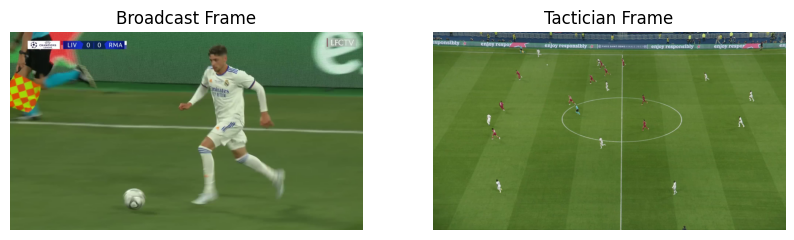


0: 384x640 3 players, 769.4ms
Speed: 9.9ms preprocess, 769.4ms inference, 12.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 players, 2 referees, 708.3ms
Speed: 3.0ms preprocess, 708.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Broadcast frame detections: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 2.])
conf: tensor([0.8264, 0.7146, 0.5605])
data: tensor([[1.4240e+03, 7.4101e+02, 1.4948e+03, 9.1189e+02, 8.2635e-01, 2.0000e+00],
        [1.3597e+03, 4.3659e+02, 1.4378e+03, 5.2586e+02, 7.1458e-01, 2.0000e+00],
        [1.2984e+03, 2.6386e+02, 1.3357e+03, 3.1524e+02, 5.6052e-01, 2.0000e+00]])
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([3, 6])
xywh: tensor([[1459.4089,  826.4535,   70.8562,  170.8784],
        [1398.7451,  481.2256,   78.1505,   89.2714],
        [1317.0507,  289.5489,   37.2458,   51.3743]])
xywhn: tensor([[0.7601, 0.7652, 0.0369, 0.1582],
        [0.7285, 0.4456, 0.040

In [40]:
# Check why no players are detected in both frames

# 1. Visualize the frames to ensure they are loaded correctly
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title("Broadcast Frame")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.title("Tactician Frame")
plt.axis('off')
plt.show()

# 2. Run YOLO detection directly and print results for debugging
results1 = model(frame1)[0]
results2 = model(frame2)[0]
print("Broadcast frame detections:", results1.boxes)
print("Tactician frame detections:", results2.boxes)

# 3. Check if class 0 exists in the detections
detected_classes1 = [int(box.cls) for box in results1.boxes]
detected_classes2 = [int(box.cls) for box in results2.boxes]
print("Classes detected in broadcast frame:", detected_classes1)
print("Classes detected in tactician frame:", detected_classes2)

# 4. If no detections or no class 0, possible issues:
# - Model is not trained for your data
# - Wrong class index for "player"
# - Frames are not suitable for detection (e.g., too dark, blurry)

In [45]:
# Detect players
broadcast_players = detect_players(frame1)
tactician_players = detect_players(frame2)

print(f"Tactician players detected: {len(tactician_players)}")
print(f"Broadcast players detected: {len(broadcast_players)}")


0: 384x640 3 players, 618.9ms
Speed: 9.1ms preprocess, 618.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 players, 2 referees, 609.3ms
Speed: 2.8ms preprocess, 609.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Tactician players detected: 0
Broadcast players detected: 0


In [44]:
# The reason broadcast_players is empty is because the detect_players function only adds detections with class 0 (assumed "player").
# However, detected_classes1 contains only class 2 (which is "player" in your model's class names).
# So, the function is filtering out all detections.

# Let's print the class mapping for clarity:
print("Class mapping:", results1.names)
print("Detected classes in broadcast frame:", detected_classes1)

# Solution: Update detect_players to use class_id 2 for "player" instead of 0.

Class mapping: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}
Detected classes in broadcast frame: [2, 2, 2]


In [46]:
def detect_players(frame, player_class_id=2):  # change default from 0 to 2
    results = model(frame)[0]
    players = []

    for box in results.boxes:
        cls_id = int(box.cls)
        if cls_id == player_class_id:  # Match to correct "player" class
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = frame[y1:y2, x1:x2]
            center = ((x1 + x2) // 2, (y1 + y2) // 2)
            players.append({'bbox': (x1, y1, x2, y2), 'crop': crop, 'center': center})

    return players


In [47]:
results1 = model(frame1)[0]
detected_classes1 = [int(box.cls) for box in results1.boxes]
print("Detected classes in broadcast frame:", detected_classes1)
print("Class names:", results1.names)  # Check what each class ID means



0: 384x640 3 players, 980.1ms
Speed: 15.6ms preprocess, 980.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Detected classes in broadcast frame: [2, 2, 2]
Class names: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}


In [48]:
broadcast_players = detect_players(frame1, player_class_id=2)
tactician_players = detect_players(frame2, player_class_id=2)

print(f"Tactician players detected: {len(tactician_players)}")
print(f"Broadcast players detected: {len(broadcast_players)}")



0: 384x640 3 players, 950.6ms
Speed: 2.0ms preprocess, 950.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 players, 2 referees, 689.7ms
Speed: 2.9ms preprocess, 689.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Tactician players detected: 22
Broadcast players detected: 3


In [49]:
# Match tactician players to broadcast players using spatial proximity (center coordinates)

def match_players_by_center(broadcast_players, tactician_players):
    # Extract centers
    broadcast_centers = np.array([p['center'] for p in broadcast_players])
    tactician_centers = np.array([p['center'] for p in tactician_players])

    # Compute distance matrix (Euclidean)
    dists = np.linalg.norm(
        tactician_centers[:, None, :] - broadcast_centers[None, :, :], axis=2
    )

    # Hungarian algorithm for optimal assignment
    tactician_indices, broadcast_indices = linear_sum_assignment(dists)

    # Assign player_id from broadcast to tactician
    matched = []
    for t_idx, b_idx in zip(tactician_indices, broadcast_indices):
        matched.append({
            'tactician_idx': t_idx,
            'broadcast_idx': b_idx,
            'player_id': b_idx,  # Use broadcast index as player_id
            'distance': dists[t_idx, b_idx]
        })

    return matched

matched_players = match_players_by_center(broadcast_players, tactician_players)

# Example: print mapping
for m in matched_players:
    print(f"Tactician player {m['tactician_idx']} -> Broadcast player {m['broadcast_idx']} (player_id={m['player_id']}, distance={m['distance']:.2f})")

Tactician player 2 -> Broadcast player 1 (player_id=1, distance=245.96)
Tactician player 7 -> Broadcast player 0 (player_id=0, distance=146.81)
Tactician player 17 -> Broadcast player 2 (player_id=2, distance=176.82)
